To measure PP1 intensities 

In [14]:
# import necessary modules
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters as filters
import skimage.color as color
from PIL import Image
import pandas as pd
from skimage.util import img_as_float
from skimage.color import label2rgb, rgb2gray,gray2rgb
from skimage import segmentation,morphology,feature,measure,filters
from scipy import ndimage as ndi
import glob
from natsort import natsorted 
import os
import glob
import re

In [15]:
# import function file
%run functions-Cytoplasm-Method1.ipynb

In [24]:
# path to the local folder for the notebooks
# change path to your folders accordingly
BASE_DIR="/Users/Trupti/01-LIDo/02-VijiProject/ImageAnalysis/" 
#path to the image folder. # change the name of the folder for different dataset
FOLDER="set2-pp1"
IMAGE_DIR=BASE_DIR + "data/XMovie/" + FOLDER
CSV_DIR = BASE_DIR + "AnalysisMethods/AnalysisResults/XMovie/" + FOLDER +"/" + "csvs/"


#### A List for the Images Folders

In [25]:
dmso=[]
cdki=[]
dmso_path = IMAGE_DIR + 'dmso'
cdki_path=IMAGE_DIR + 'cdki'

for folder in glob.glob(dmso_path + '/*'):
    dmso.append(dmso_path + '/' + folder.split('/')[-1].split('.')[0])
for folder in glob.glob(cdki_path + '/*'):
    cdki.append(cdki_path + '/' + folder.split('/')[-1].split('.')[0])     


In [26]:
# For DMSO

for i in range(len(dmso)):
    
    df_nuf2,df_pp1=method_pp1(dmso[i],FOLDER) #,nuf2_cyto,pp1_cyto,nuf2_bg,pp1_bg
    
    df=pd.merge(df_nuf2, df_pp1,  how='outer',on=['label','area']
                                                       ,suffixes=('_nuf2_CFP', '_YFP_pp1'))
    #df['nuf2_CFP_cyto']=nuf2_cyto
    #df['YFP_pp1_cyto']=pp1_cyto
    #df['nuf2_CFP_bg']=nuf2_bg
    #df['YFP_pp1_bg']=pp1_bg
    
    directory=dmso[i].split('/')[-1].split('.')[0] # to create a folder per experiment to save csvs
    path = CSV_DIR + 'dmso/' + directory
    try:
        os.makedirs(path)
    except FileExistsError:
    # directory already exists
        pass
    check_nan_in_df = df.isnull().values.any()
    print("There are %d NaN values in %s " %(check_nan_in_df , directory))
    
  
    df.to_csv(path + '/' + 'particles'+'.csv') 
   

In [27]:
# For CDKi

for i in range(len(cdki)):
    
    df_nuf2,df_pp1=method_pp1(cdki[i],FOLDER)#,nuf2_cyto_value,pp1_cyto_value,nuf2_bg,pp1_bg
    
    df=pd.merge(df_nuf2, df_pp1,  how='outer',on=['label','area']
                                                       ,suffixes=('_nuf2_CFP', '_YFP_pp1'))
    #df['nuf2_CFP_cyto']=nuf2_cyto_value
    #df['YFP_pp1_cyto']=pp1_cyto_value
    #df['nuf2_CFP_bg']=nuf2_bg
    #df['YFP_pp1_bg']=pp1_bg
    
    
    
    directory=cdki[i].split('/')[-1].split('.')[0] # to create a folder per experiment to save csvs
    path = CSV_DIR + 'cdki/' + directory
    try:
        os.makedirs(path)
    except FileExistsError:
    # directory already exists
        pass
    
    check_nan_in_df = df.isnull().values.any()
    print("There are %d NaN values in %s " %(check_nan_in_df , directory))
    df.to_csv(path + '/' + 'particles'+'.csv') 
   

### Plots

In [28]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook",font_scale=1, rc={"lines.linewidth":2.5})

# path to save graphs
GRAPH_DIR=BASE_DIR + "AnalysisMethods/AnalysisResults/XMovie/" + FOLDER + "/" + "graphs/"


In [29]:
# plot graphs 
# dmso vs cdki
# The paths are for the generated csv files
dmso_csv=[]
cdki_csv=[]
dmso_path = CSV_DIR + 'dmso'
cdki_path=CSV_DIR + 'cdki'

for folder in natsorted(glob.glob(dmso_path + '/*')):
    dmso_csv.append(dmso_path + '/' + folder.split('/')[-1].split('.')[0])
    
for folder in natsorted(glob.glob(cdki_path + '/*')):
    cdki_csv.append(cdki_path + '/' + folder.split('/')[-1].split('.')[0])  


In [30]:
# read cdki csvs to a dataframe
cell_count=0
df_graph_cdki=pd.DataFrame()
for i in range(len(cdki_csv)):
    df_cdki=pd.read_csv(cdki_csv[i]+'/'+'Particles.csv')
    
    df_cdki['YFP_pp1@kt/YFP_pp1@cyto']= df_cdki['mean_intensity_YFP_pp1']/df_cdki['YFP_pp1_cyto']
   
    
    df_cdki['nuf2_CFP@kt/nuf2_CFP@cyto']= df_cdki['mean_intensity_nuf2_CFP']/df_cdki['nuf2_CFP_cyto']
    df_cdki['YFP_pp1@kt/YFP_pp1@cyto:nuf2_CFP@kt/nuf2_CFP@cyto']= df_cdki['YFP_pp1@kt/YFP_pp1@cyto'] / df_cdki['nuf2_CFP@kt/nuf2_CFP@cyto']
    df_cdki['condition']='cdki'
    expt_name=re.sub(r'^.+/([^/]+)$', r'\1', cdki_csv[i])
    df_cdki['Experiment']= expt_name#'cdki_%d'%i
    fname=FOLDER +'cdki_'+ str(i)
    df_cdki.to_csv(BASE_DIR  + 'GraphAnalysis/pp1/' + fname +'.csv')
    #df_cdki_final=outliers_pp1(df_cdki)
    df_graph_cdki=pd.concat([df_graph_cdki,df_cdki],ignore_index=True)
df_graph_cdki = df_graph_cdki.drop(columns=["Unnamed: 0"], axis=1)
df_graph_cdki.head()

df_graph_cdki.to_csv(BASE_DIR  + 'GraphAnalysis/pp1/cdki_pp1_graphs'+'.csv') 


In [31]:
# read dmso csvs to a dataframe
cell_count=0
df_graph_dmso=pd.DataFrame()
for i in range(len(dmso_csv)):
    df_dmso=pd.read_csv(dmso_csv[i]+'/'+'Particles.csv')
    
    df_dmso['YFP_pp1@kt/YFP_pp1@cyto']= df_dmso['mean_intensity_YFP_pp1']/df_dmso['YFP_pp1_cyto']
   
    
    df_dmso['nuf2_CFP@kt/nuf2_CFP@cyto']= df_dmso['mean_intensity_nuf2_CFP']/df_dmso['nuf2_CFP_cyto']
    df_dmso['YFP_pp1@kt/YFP_pp1@cyto:nuf2_CFP@kt/nuf2_CFP@cyto']= df_dmso['YFP_pp1@kt/YFP_pp1@cyto'] / df_dmso['nuf2_CFP@kt/nuf2_CFP@cyto']
    df_dmso['condition']='dmso'
    expt_name=re.sub(r'^.+/([^/]+)$', r'\1', dmso_csv[i])
    df_dmso['Experiment']= expt_name#'dmso_%d'%i
    #df_dmso_final=outliers_pp1(df_dmso)
    df_graph_dmso=pd.concat([df_graph_dmso,df_dmso],ignore_index=True)
    cell_count+=1
df_graph_dmso = df_graph_dmso.drop(columns=["Unnamed: 0"], axis=1)    
df_graph_dmso.head()
df_graph_dmso.to_csv(BASE_DIR  + 'GraphAnalysis/pp1/dmso_pp1_graphs'+'.csv') 


In [32]:
df_graph=pd.DataFrame()
df_graph=pd.concat([df_graph,df_graph_cdki,df_graph_dmso],ignore_index=True)
print(len(df_graph_cdki))
print(len(df_graph_dmso))
print(len(df_graph))
df_graph.head()
df_graph.to_csv(BASE_DIR  + 'GraphAnalysis/pp1/yfp_pp1_combined_graphs'+'.csv') 
df_graph.head()

5861
2723
8584


,label,area,mean_intensity_nuf2_CFP,fname_nuf2_CFP,nuf2_CFP_cyto,nuf2_CFP_bg,mean_intensity_YFP_pp1,fname_YFP_pp1,YFP_pp1_cyto,YFP_pp1_bg,YFP_pp1@kt/YFP_pp1@cyto,nuf2_CFP@kt/nuf2_CFP@cyto,YFP_pp1@kt/YFP_pp1@cyto:nuf2_CFP@kt/nuf2_CFP@cyto,condition,Experiment
0,0_1,19,5570.684211,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...,4463.260198,4300.9125,9768.947368,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...,9196.491695,4986.7925,1.062247,1.248120,0.851078,cdki,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...
1,0_2,14,5776.571429,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...,4463.260198,4300.9125,10591.928571,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...,9196.491695,4986.7925,1.151736,1.294249,0.889887,cdki,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...
2,0_3,90,6541.900000,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...,4463.260198,4300.9125,7425.888889,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...,9196.491695,4986.7925,0.807470,1.465722,0.550902,cdki,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...
3,1_1,16,5266.375000,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...,4470.864569,4339.0000,9842.125000,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...,8310.666185,5086.3500,1.184276,1.177932,1.005386,cdki,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...
4,1_2,12,5276.750000,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...,4470.864569,4339.0000,10472.416667,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...,8310.666185,5086.3500,1.260118,1.180253,1.067668,cdki,Expt2021_006_Set2_HeLaYFP-PP1_Nuf2-CFP_STLC_MG...


### pp1@kt/pp1@cyto

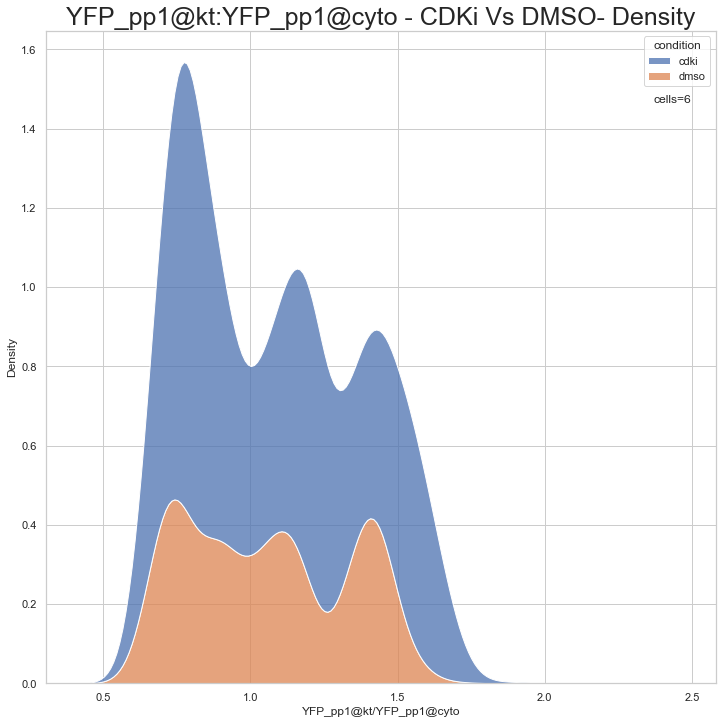

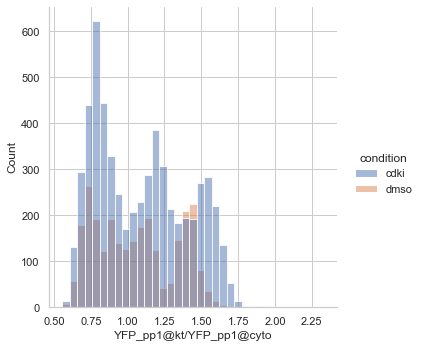

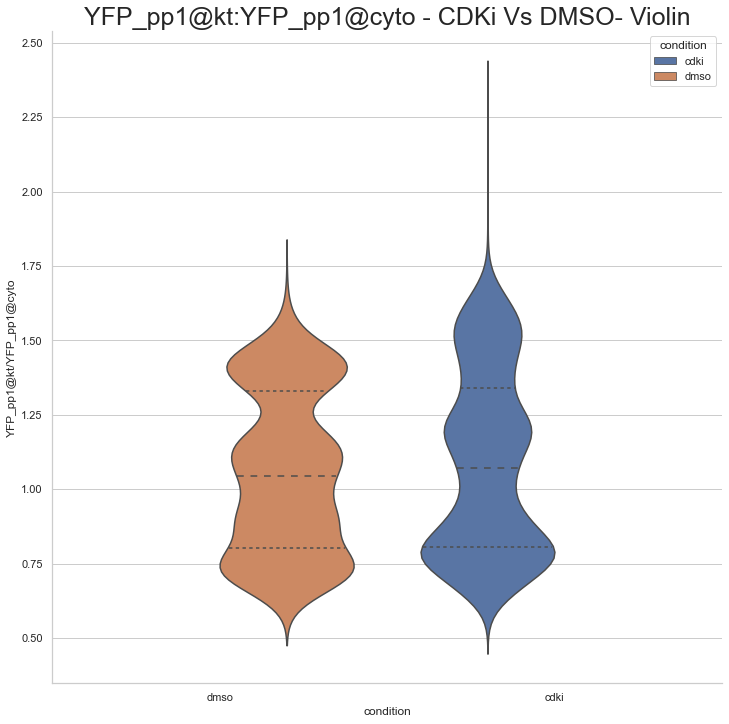

In [33]:
### checking plots

import seaborn as sns

title="YFP_pp1@kt:YFP_pp1@cyto - CDKi Vs DMSO- Density"
plt.figure(figsize=(12,12))
sns.set_theme(style="whitegrid")

sns_plot=sns.kdeplot(data=df_graph, x="YFP_pp1@kt/YFP_pp1@cyto",hue='condition', multiple="stack").set_title(title,fontsize=25)
plt.figtext(0.85, 0.8, 'cells=%s'%(cell_count), horizontalalignment='center',verticalalignment='center')
sns_plot=sns.displot(data=df_graph, x="YFP_pp1@kt/YFP_pp1@cyto",hue='condition')
#plt.figtext(1, 0.4, 'cells=%s'%(cell_count), horizontalalignment='center',verticalalignment='center')


title="YFP_pp1@kt:YFP_pp1@cyto - CDKi Vs DMSO- Violin"
plt.figure(figsize=(12,12))
sns.set_theme(style="whitegrid")


# Draw a nested violinplot and split the violins for easier comparison
sns_plot=sns.violinplot(data=df_graph, x="condition", y="YFP_pp1@kt/YFP_pp1@cyto", hue="condition",
              inner="quart",order=["dmso","cdki"]
               ).set_title(title,fontsize=25)
sns.despine(right=True)

from scipy import stats



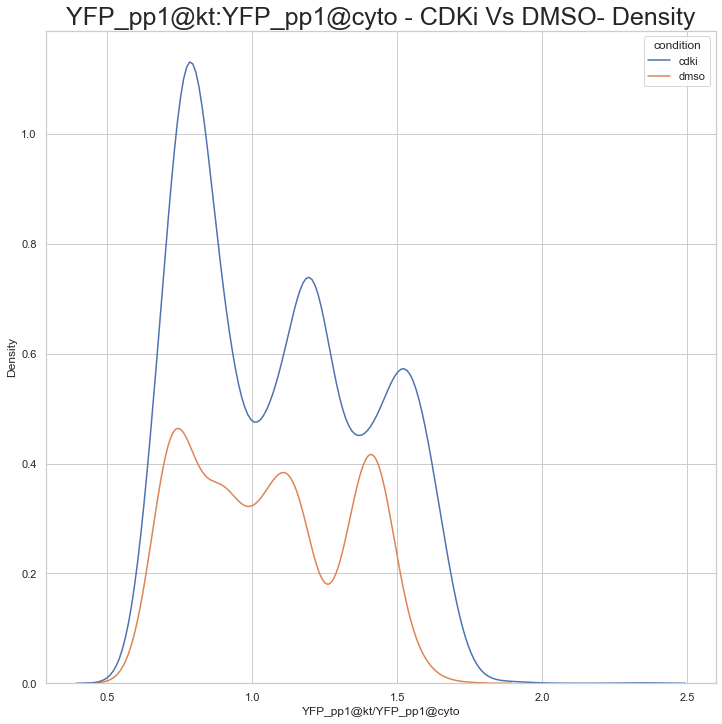

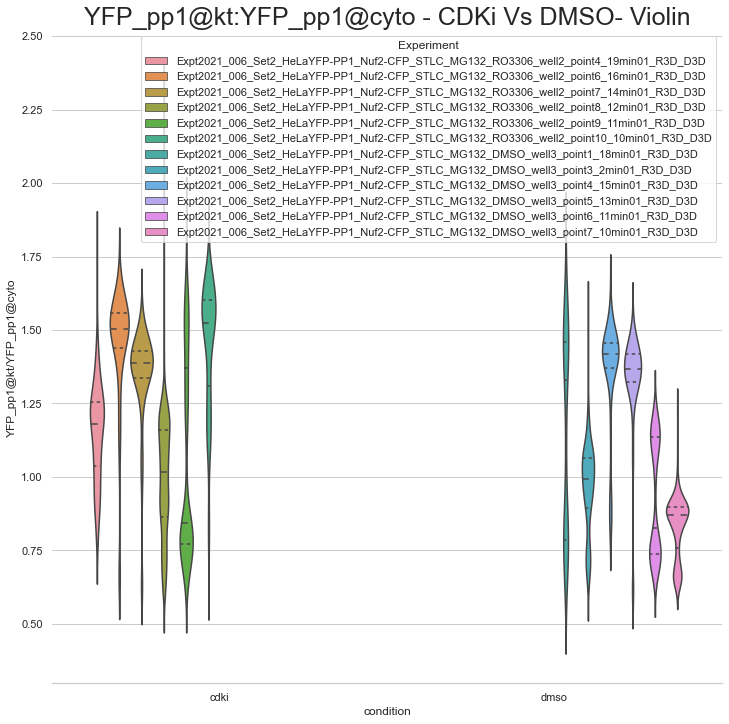

In [34]:
import seaborn as sns

title="YFP_pp1@kt:YFP_pp1@cyto - CDKi Vs DMSO- Density"
plt.figure(figsize=(12,12))
sns.set_theme(style="whitegrid")

sns_plot=sns.kdeplot(data=df_graph, x="YFP_pp1@kt/YFP_pp1@cyto",hue='condition').set_title(title,fontsize=25)
#sns_plot.figure.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)


title="YFP_pp1@kt:YFP_pp1@cyto - CDKi Vs DMSO- Violin"
plt.figure(figsize=(12,12))
sns.set_theme(style="whitegrid")


# Draw a nested violinplot and split the violins for easier comparison
sns_plot=sns.violinplot(data=df_graph, x="condition", y="YFP_pp1@kt/YFP_pp1@cyto", hue="Experiment",
              inner="quart",
               ).set_title(title,fontsize=25)

#sns_plot.figure.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)
sns.despine(left=True)

#title="pp1@kt:pp1@cyto - CDKi Vs DMSO- Box"
#plt.figure(figsize=(12,12))
#sns_plot=sns.boxplot(x="condition", y="pp1@kt/pp1@cyto",hue="Experiment",data=df_graph).set_title(title)
#sns_plot.figure.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)

#title="pp1@kt:pp1@cyto - CDKi Vs DMSO- Bar"
#plt.figure(figsize=(12,12))

#sns_plot = sns.barplot(
#        data=df_graph,
#        x="condition",
#        y="pp1@kt/pp1@cyto",
#        hue="Experiment"
#    ).set_title(title)
#sns_plot.figure.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)
plt.show()





### nuf2@kt : nuf2@cyto

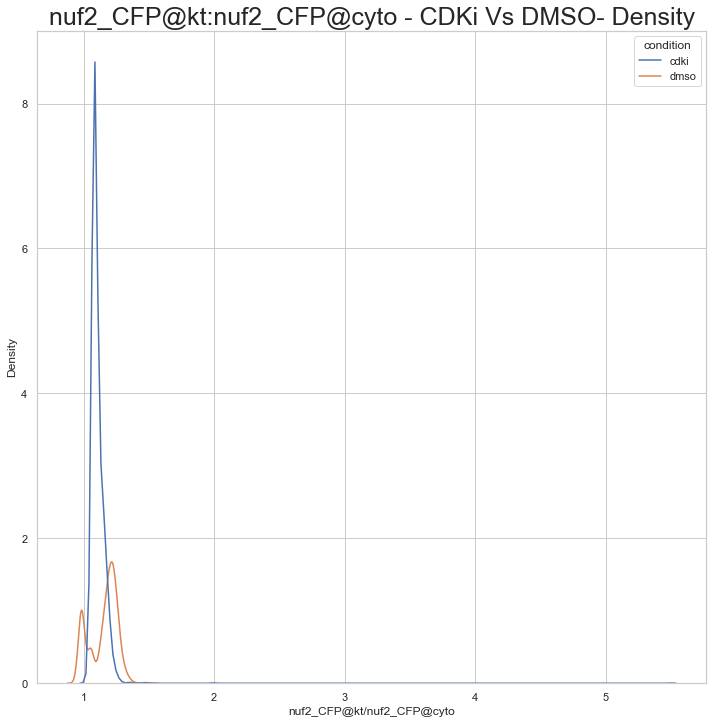

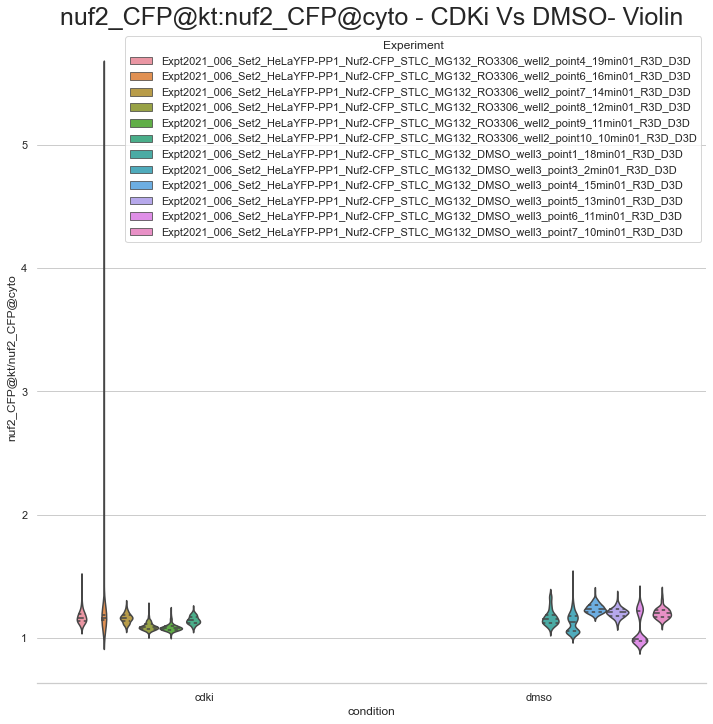

In [14]:
import seaborn as sns
title="nuf2_CFP@kt:nuf2_CFP@cyto - CDKi Vs DMSO- Density"
plt.figure(figsize=(12,12))
sns.set_theme(style="whitegrid")

sns_plot=sns.kdeplot(data=df_graph, x="nuf2_CFP@kt/nuf2_CFP@cyto",hue='condition').set_title(title,fontsize=25)
sns_plot.figure.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)

title="nuf2_CFP@kt:nuf2_CFP@cyto - CDKi Vs DMSO- Violin"
plt.figure(figsize=(12,12))
sns.set_theme(style="whitegrid")
# Draw a nested violinplot and split the violins for easier comparison
sns_plot=sns.violinplot(data=df_graph, x="condition", y="nuf2_CFP@kt/nuf2_CFP@cyto", hue="Experiment",
              inner="quart",
               ).set_title(title,fontsize=25)

sns_plot.figure.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)
sns.despine(left=True)

plt.show()

### pp1@kt/pp1@cyto:nuf2@kt/nuf2@cyto

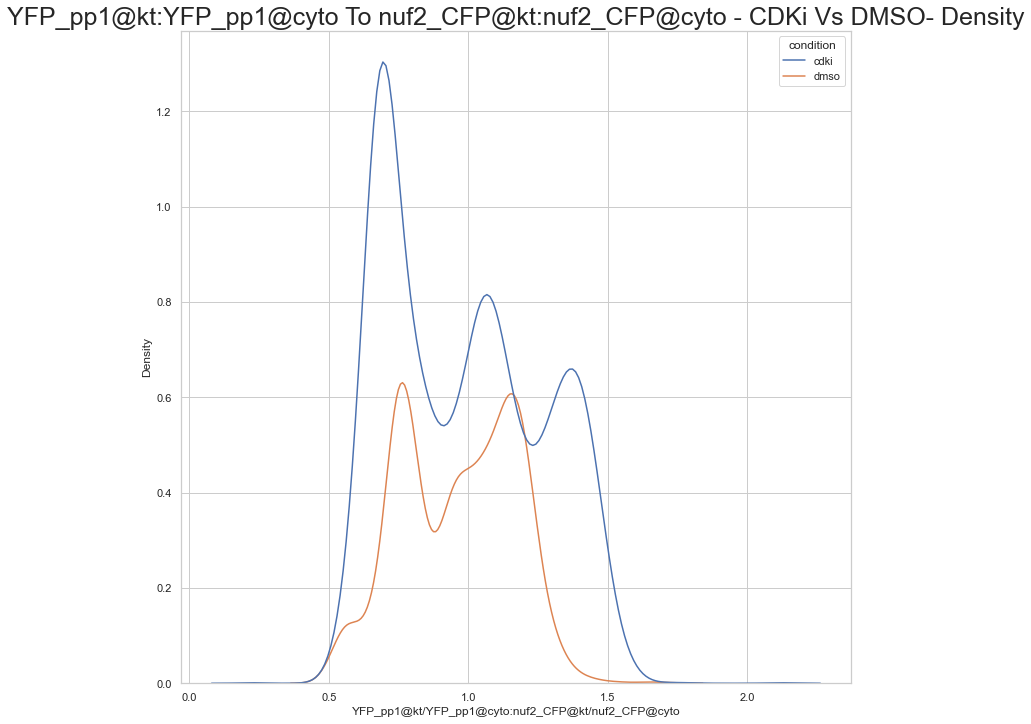

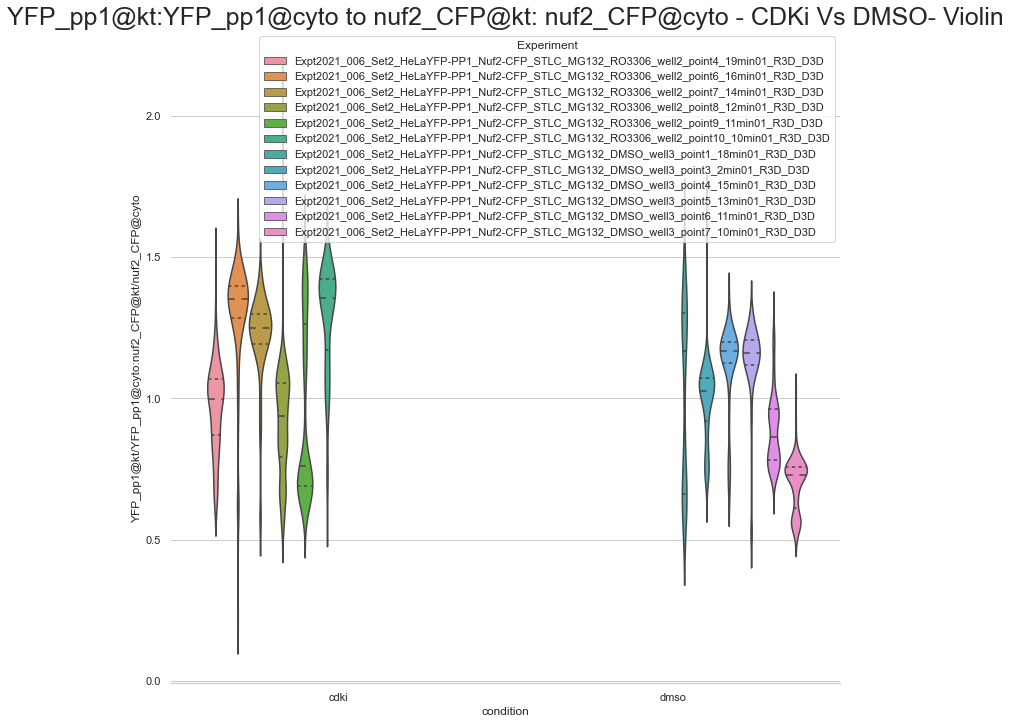

In [15]:
import seaborn as sns
title="YFP_pp1@kt:YFP_pp1@cyto To nuf2_CFP@kt:nuf2_CFP@cyto - CDKi Vs DMSO- Density"
plt.figure(figsize=(12,12))
sns.set_theme(style="whitegrid")

sns_plot=sns.kdeplot(data=df_graph, x="YFP_pp1@kt/YFP_pp1@cyto:nuf2_CFP@kt/nuf2_CFP@cyto",hue='condition').set_title(title,fontsize=25)
sns_plot.figure.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)

title="YFP_pp1@kt:YFP_pp1@cyto to nuf2_CFP@kt: nuf2_CFP@cyto - CDKi Vs DMSO- Violin"
plt.figure(figsize=(12,12))
sns.set_theme(style="whitegrid")
# Draw a nested violinplot and split the violins for easier comparison
sns_plot=sns.violinplot(data=df_graph, x="condition", y="YFP_pp1@kt/YFP_pp1@cyto:nuf2_CFP@kt/nuf2_CFP@cyto", hue="Experiment",
              inner="quart",
               ).set_title(title,fontsize=25)

sns_plot.figure.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)
sns.despine(left=True)

plt.show()

In [16]:
import seaborn as sns
title="nuf2_CFP@kt:nuf2_CFP@cyto To YFP_pp1@kt:YFP_pp1@cyto - CDKi Vs DMSO- Density"
plt.figure(figsize=(12,12))
sns.set_theme(style="whitegrid")

sns_plot=sns.kdeplot(data=df_graph, x="nuf2_CFP@kt/nuf2_CFP@cyto:YFP_pp1@kt/YFP_pp1@cyto",hue='condition').set_title(title,fontsize=25)
sns_plot.figure.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)

title="nuf2_CFP@kt:nuf2_CFP@cyto To YFP_pp1@kt:YFP_pp1@cyto- CDKi Vs DMSO- Violin"
plt.figure(figsize=(12,12))
sns.set_theme(style="whitegrid")
# Draw a nested violinplot and split the violins for easier comparison
sns_plot=sns.violinplot(data=df_graph, x="condition", y='nuf2_CFP@kt/nuf2_CFP@cyto:YFP_pp1@kt/YFP_pp1@cyto', hue="Experiment",
              inner="quart",
               ).set_title(title,fontsize=25)

sns_plot.figure.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)
sns.despine(left=True)

plt.show()

ValueError: Could not interpret value `nuf2_CFP@kt/nuf2_CFP@cyto:YFP_pp1@kt/YFP_pp1@cyto` for parameter `x`

<Figure size 864x864 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.5)
title='PairPlot - Condition'
sns_plot=sns.pairplot(df_graph, hue="condition")

replacements = {'mean_intensity_YFP_pp1': 'YFP_pp1_int','mean_intensity_nuf2_CFP': 'nuf2_CFP_int', 'YFP_pp1@kt/YFP_pp1@cyto': 'YFP_pp1@kt/YFP_pp1@cyto',
                'nuf2_CFP@kt/nuf2_CFP@cyto': 'nuf2_CFP@kt/nuf2_CFP@cyto','nuf2_CFP@kt/nuf2_CFP@cyto:YFP_pp1@kt/YFP_pp1@cyto':'nuf2@kt/nuf2@cyto:YFP_pp1@kt/YFP_pp1@cyto',
               'YFP_pp1@kt/YFP_pp1@cyto:nuf2_CFP@kt/nuf2_CFP@cyto':'YFP_pp1@kt/YFP_pp1@cyto:nuf2_CFP@kt/nuf2_CFP@cyto'}

for i in range(6):
    for j in range(6):
        xlabel = sns_plot.axes[i][j].get_xlabel()
        ylabel = sns_plot.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            sns_plot.axes[i][j].set_xlabel(replacements[xlabel],rotation=90)
           
        if ylabel in replacements.keys():
            sns_plot.axes[i][j].set_ylabel(replacements[ylabel],rotation=0,ha="right")
            
            


sns_plot.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
title="PairPlot - Experiment"
sns.set(font_scale=1.5)

sns_plot=sns.pairplot(df_graph, hue="Experiment")

replacements = {'mean_intensity_YFP_pp1': 'YFP_pp1_int','mean_intensity_nuf2_CFP': 'nuf2_CFP_int', 'YFP_pp1@kt/YFP_pp1@cyto': 'YFP_pp1@kt/YFP_pp1@cyto',
                'nuf2_CFP@kt/nuf2_CFP@cyto': 'nuf2_CFP@kt/nuf2_CFP@cyto','nuf2_CFP@kt/nuf2_CFP@cyto:YFP_pp1@kt/YFP_pp1@cyto':'nuf2@kt/nuf2@cyto:YFP_pp1@kt/YFP_pp1@cyto',
               'YFP_pp1@kt/YFP_pp1@cyto:nuf2_CFP@kt/nuf2_CFP@cyto':'YFP_pp1@kt/YFP_pp1@cyto:nuf2_CFP@kt/nuf2_CFP@cyto'}


for i in range(6):
    for j in range(6):
        xlabel = sns_plot.axes[i][j].get_xlabel()
        ylabel = sns_plot.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            sns_plot.axes[i][j].set_xlabel(replacements[xlabel],rotation=90)
        if ylabel in replacements.keys():
            sns_plot.axes[i][j].set_ylabel(replacements[ylabel],rotation=0,ha="right")

sns_plot.savefig(GRAPH_DIR+title, bbox_inches="tight",dpi=300)
plt.show()